## Week 8 Optional Programming

(Optional Programming Exercises)

    Download and experiment with the sparse modeling free software packages linked in the class website.
    Compare the results of sparse modeling image denoising with those of DCT-based image denoising as implemented in ipol.im
    Consider an image and select K patches from it as the dictionary; select those patches at random. With this dictionary perform sparse modeling image denoising and compare with the results obtained when learning the dictionary.
    Pick a particular example of sparse modeling image denoising and experiment with different dictionary sizes. Plot the histogram of atoms usage, meaning the number of times each atom is used considering all image patches.
    
http://www.jmlr.org/papers/volume11/mairal10a/mairal10a.pdf
    
http://spams-devel.gforge.inria.fr/

http://spams-devel.gforge.inria.fr/doc-python/html/index.html

In [1]:
from __future__ import division, print_function

import spams
import numpy as np
# from skimage import io
import time
from PIL import Image

from matplotlib import pyplot as plt
import time

# from skimage import img_as_float
from skimage import io
# from skimage.color import rgb2gray
from skimage.util import random_noise
%matplotlib inline

# Plotting stuff

def plot_1xc(imgs_list, titles_list, save_file=None):
    cols = len(imgs_list)
    i = 0
    
    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,15))
    for c in range(cols):
        axes[c].imshow(imgs_list[i], cmap="gray", interpolation="nearest")
        axes[c].set_title(titles_list[i], size=20)
        axes[c].set_xticks([])
        axes[c].set_yticks([])
        i = i + 1
    plt.tight_layout();
    
    if not (save_file == None):
        filename = time.strftime("%Y%m%d_%H%M") + "_" + save_file + ".png"
        fig.savefig(filename, bbox_inches='tight')
        
def plot_rxc(imgs_list, titles_list, ncol=3, save_file=None):
    cols = ncol
    rows = np.ceil(len(imgs_list)/cols).astype(int)
    if rows==1:
        plot_1xc(imgs_list, titles_list, save_file)
    else:
        i = 0
    
        fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15*rows/cols))
        for r in range(rows):
            for c in range(cols):
                if i < len(imgs_list):
                    axes[r,c].imshow(imgs_list[i], cmap="gray", interpolation="nearest")
                    axes[r,c].set_title(titles_list[i], size=20)
                    axes[r,c].set_xticks([])
                    axes[r,c].set_yticks([])
                i = i + 1
        plt.tight_layout();
    
        if not (save_file == None):
            filename = time.strftime("%Y%m%d_%H%M") + "_" + save_file + ".png"
            fig.savefig(filename, bbox_inches='tight')

In [2]:
def _objective(X,D,param,imgname = None):
    print ('Evaluating cost function...')
    lparam = _extract_lasso_param(param)
    alpha = spams.lasso(X,D = D,**lparam)
    # NB : as alpha is sparse, D*alpha is the dot product
    xd = X - D * alpha
    R = np.mean(0.5 * (xd * xd).sum(axis=0) + param['lambda1'] * np.abs(alpha).sum(axis=0))
    print ("objective function: %f" %R)
    #* display ?
    if imgname != None:
        img = spams.displayPatches(D)
        print ("IMG %s" %str(img.shape))
        x = np.uint8(img[:,:,0] * 255.)
        image = Image.fromarray(x,mode = 'L')
        image.save("%s.png" %imgname)
    
def _extract_lasso_param(f_param):
    lst = [ 'L','lambda1','lambda2','mode','pos','ols','numThreads','length_path','verbose','cholesky']
    l_param = {'return_reg_path' : False}
    for x in lst:
        if x in f_param:
            l_param[x] = f_param[x]
    return l_param

Below is sample code from the SPAmS website.

In [3]:
# img_file = '../images/lena512color.tiff'
img_file = '../images/boat.png'
# img_file = '../images/bossier_gray.jpg'
try:
    img = Image.open(img_file)
    # img = io.imread("../images/boat.png")
except:
    print ("Cannot load image %s : skipping test" %img_file)
I = np.array(img) / 255.
if I.ndim == 3:
    A = np.asfortranarray(I.reshape((I.shape[0],I.shape[1] * I.shape[2])))
    rgb = True
else:
    A = np.asfortranarray(I)
    rgb = False

m = 8;n = 8;
X = spams.im2col_sliding(A,m,n,rgb)

X = X - np.tile(np.mean(X,0),(X.shape[0],1))
# X = np.asfortranarray(X / np.tile(np.sqrt((X * X).sum(axis=0)),(X.shape[0],1)),dtype = myfloat)
X = np.asfortranarray(X / np.tile(np.sqrt((X * X).sum(axis=0)),(X.shape[0],1)),dtype = np.float)
# learns a dictionary with 100 elements
# param = { 'K' : 100, 'lambda1' : 0.15, 'numThreads' : 4, 'batchsize' : 400, 'iter' : 1000}
# learns a dictionary with 25 elements
param = { 'K' : 25, 'lambda1' : 0.15, 'numThreads' : 4, 'batchsize' : 400, 'iter' : 1000}

########## FIRST EXPERIMENT ###########
tic = time.time()
D = spams.trainDL(X,**param)
tac = time.time()
t = tac - tic
print ('time of computation for Dictionary Learning: %f' %t)

##param['approx'] = 0
# save dictionnary as dict.png
_objective(X,D,param,'dict')



time of computation for Dictionary Learning: 7.891638
Evaluating cost function...
objective function: 0.332737
IMG (46, 46, 1)


/home/robert/anaconda2/lib/python2.7/site-packages/spams.py:424: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if D == None:


In [4]:
run_this = False

if run_this:
    #### SECOND EXPERIMENT ####
    print ("*********** SECOND EXPERIMENT ***********")

    X1 = X[:,0:X.shape[1]/2]
    X2 = X[:,X.shape[1]/2 -1:]
    param['iter'] = 500
    tic = time.time()
    (D,model) = spams.trainDL(X1,return_model = True,**param)
    tac = time.time()
    t = tac - tic
    print ('time of computation for Dictionary Learning: %f\n' %t)

    _objective(X,D,param,'dict1')

    # Then reuse the learned model to retrain a few iterations more.
    param2 = param.copy()
    param2['D'] = D
    tic = time.time()
    (D,model) = spams.trainDL(X2,return_model = True,model = model,**param2)
    tac = time.time()
    t = tac - tic
    print ('time of computation for Dictionary Learning: %f' %t)
    _objective(X,D,param,'dict2')

Which patches contain pixel(i,j)?  Here is a sketch of the image and three patches that contain the pixel.


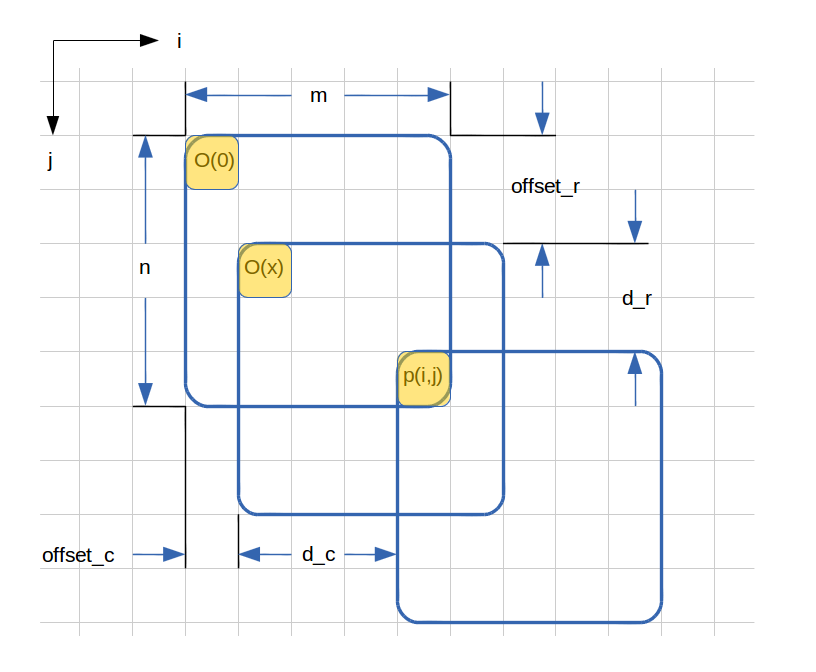

In [5]:
from IPython.display import Image
Image(filename='./patch_sketch.png', width=500) 

The target pixel is p(i,j).  Three patches to which the pixel belongs are shown in blue.  The origin of each patch is the upper left corner.  The location of the patch origin with respect to the whole image is

$$
\begin{align}
O(x) &= (ii,jj) \\
ii &= i - (m-1) + offset_c \\
&= i - m + offset_c + 1\\
jj &= j - (n-1) + offset_r \\
&= j - n + offset_r + 1 \\
\end{align}
$$

The location of the target pixel with respect to the patch origin is

$$
\begin{align}
i_{patch} &= d_c \\
&= m - offset_c - 1 \\
j_{patch} &= n - offset_r - 1 \\
\end{align}
$$


In [6]:
# test it
M = 5; N = 5; offset_c = 1; offset_r = 2; i = 10; j = 11
# ii should be 7, jj should be 9
# i_patch should be 3, j_patch should be 2
ii = i - M + offset_c + 1
jj = j - N + offset_r + 1
i_patch = M - offset_c - 1
j_patch = N - offset_r - 1
print(ii==7, jj==9, i_patch==3, j_patch==2)


True True True True


Our image has been converted to column format.  The matrix X has been normalized.  The matrix A should contain original image values.  Each column contains a patch with origin at the top left corner.  We need the index in the column-formatted matrix.  

Let's see if we can find the patch with origin at (i,j) = (250,100)

In [7]:
patch_as_col = np.zeros(m*n)
N = 0; i = 250; j = 100
X_test = spams.im2col_sliding(A,m,n,rgb)

for c in (j + np.arange(8)):
    for r in (i + np.arange(8)):
        patch_as_col[N] = I[r,c]
        N += 1
X_test_index = i + j*(512-n+1)
patch_as_col - X_test[:, X_test_index]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

Now we need to find our target pixel in the column.

In [8]:
# offset_r = n-1; offset_c = m-1
# offset_r = 0; offset_c = 0
offset_r = 1; offset_c = 2
origin_pix = I[i,j]
all_match = True
for offset_r in range(n):
    for offset_c in range(m):
        target_pix = I[i+offset_c, j+offset_r]
        patch_pix = patch_as_col[offset_c + offset_r*n]
        if not (np.abs(target_pix - patch_pix) < 1e-6):
            print("Mismatch", offset_r, offset_c)
            all_match=False

print("All match:", all_match)


All match: True


We really need to start with the target pixel location, get the patch origin, get the patch column, then extract the target pixel from the patch column.

In [9]:
def get_patch_origin_indices(target_indices, offset_r, offset_c):
    return (target_indices[0]-offset_c, target_indices[1]-offset_r)

def get_patch_as_column(origin_indices, column_matrix, image_height, n):
    column_matrix_index = origin_indices[0] + origin_indices[1]*(image_height-n+1)
    return column_matrix[:, column_matrix_index]

def get_target_from_column(patch_column, offset_r, offset_c, n):
    return patch_column[offset_c + offset_r*n]

# Test with original image data in column-matrix format
miscount = 0
X_test = spams.im2col_sliding(A,m,n,rgb)

for r in range(n, I.shape[0]-n-1):
    for c in range(m, I.shape[1]-m-1):
        for offset_r in range(n):
            for offset_c in range(m):
                target_indices = (r,c)
                origin_indices = get_patch_origin_indices(target_indices, offset_r, offset_c)
                patch_column = get_patch_as_column(origin_indices, X_test, I.shape[1], n)
                target_from_patch = get_target_from_column(patch_column, offset_r, offset_c, n)
                if not (np.abs(I[target_indices] - target_from_patch) < 1e-6):
                    miscount +=1
print("Error count:", miscount)                

Error count: 0


In [10]:
def reconstruct_image(I_noisy, dict_size, num_features, normalize=False):
    A = np.asfortranarray(I_noisy)
    rgb = False

    m = 8;n = 8;
    X = spams.im2col_sliding(A,m,n,rgb)

    X = np.asfortranarray(X)
    if normalize:
        X = X - np.tile(np.mean(X,0),(X.shape[0],1))
        X = np.asfortranarray(X / np.tile(np.sqrt((X * X).sum(axis=0)),(X.shape[0],1)),dtype = np.float)


    param = { 'K' : dict_size, 'lambda1' : 0.15, 'numThreads' : 4, 
             'batchsize' : 400, 'iter' : 1000}

    D = spams.trainDL(X,**param)
    # Get our alphas for each patch
    if num_features > dict_size:
        num_features = dict_size
    alphas = spams.omp(X, D, L=num_features)
    D_alphas = D * alphas

    I_new = np.zeros_like(I_noisy)

    for r in range(n, I.shape[0]-n-1):
        for c in range(m, I.shape[1]-m-1):
            contributing_pixels = np.zeros(m*n)
            pix_num = 0
            for offset_r in range(n):
                for offset_c in range(m):                
                    target_indices = (r,c)
                    origin_indices = get_patch_origin_indices(target_indices, offset_r, offset_c)
                    patch_column = get_patch_as_column(origin_indices, D_alphas, I.shape[1], n)
                    target_from_patch = get_target_from_column(patch_column, offset_r, offset_c, n)
                    contributing_pixels[pix_num] = target_from_patch
                    pix_num += 1
            I_new[r,c] = np.mean(contributing_pixels)
    
    return(I_new)


0
1


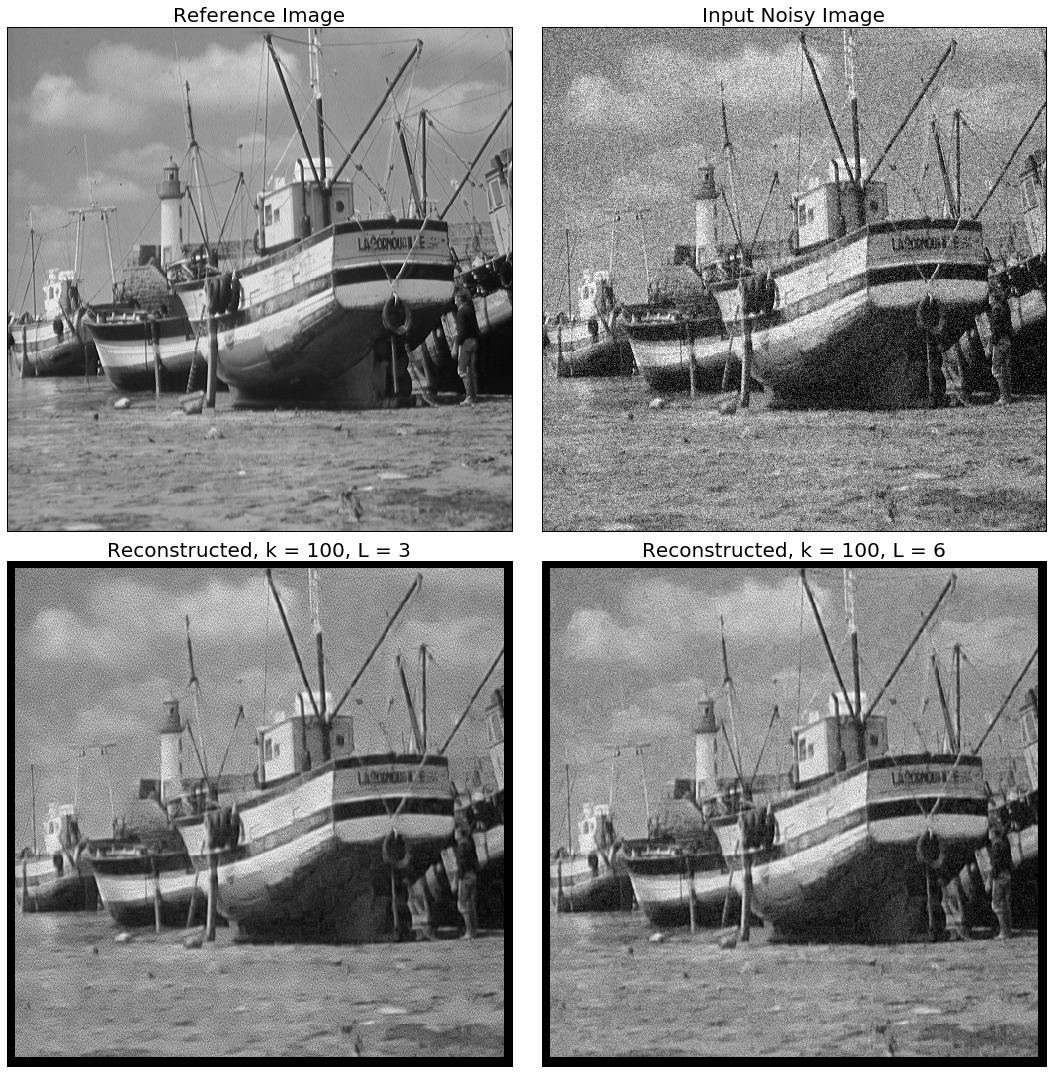

In [11]:
I = np.array(img) / 255.
I_noisy = random_noise(I, mode='gaussian', var=0.01)

ims = []
ims.append(I)
ims.append(I_noisy)
titles = []
titles.append("Reference Image")
titles.append("Input Noisy Image")

count = 0

for dict_size in [100]:
    for num_features in [3, 6]:
        print(count)
        ims.append(reconstruct_image(I_noisy, dict_size, num_features, normalize=False))
        # ims.append(reconstruct_image(I_noisy, dict_size, num_features, normalize=True))
        titles.append("Reconstructed, k = " + str(dict_size) + ", L = " + str(num_features))
        count += 1
        
plot_rxc(ims, titles, ncol=2, save_file="denoising")

In [12]:
from skimage.restoration import denoise_tv_chambolle

I_tv = denoise_tv_chambolle(I_noisy, weight=0.15, multichannel=False)
# plot_rxc([I, I_noisy, I_tv], ["I", "I_noisy", "I_tv"])

In [13]:
run_this = False

if run_this:

    #################### THIRD & FOURTH EXPERIMENT ######################
    # let us add sparsity to the dictionary itself

    print ('*********** THIRD EXPERIMENT ***********')
    param['modeParam'] = 0
    param['iter'] = 1000
    param['gamma1'] = 0.3
    param['modeD'] = 1

    tic = time.time()
    D = spams.trainDL(X,**param)
    tac = time.time()
    t = tac - tic
    print ('time of computation for Dictionary Learning: %f' %t)
    _objective(X,D,param)

    print ('*********** FOURTH EXPERIMENT ***********')
    param['modeParam'] = 0
    param['iter'] = 1000
    param['gamma1'] = 0.3
    param['modeD'] = 3

    tic = time.time()
    D = spams.trainDL(X,**param)
    tac = time.time()
    t = tac - tic
    print ('time of computation for Dictionary Learning: %f' %t)
    _objective(X,D,param)